In [8]:
import sys
import numpy
import argparse
from dataset import Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix,accuracy_score
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Input,Dense,Dropout
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import matplotlib.cm as colormap
from keras.callbacks import ModelCheckpoint

In [2]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(24, 9)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(numpy.linspace(0, 1, len(history))))
    for i in xrange(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

In [3]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(24, 9)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(numpy.linspace(0, 1, len(history))))
    for i in xrange(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

In [4]:
dataset = 'vgg16-cg.pkl'

In [5]:
ds = Dataset()
X, y, list_fams, no_imgs = ds.load(dataset)

In [6]:
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [9]:
# Create stratified k-fold subsets
kfold = 10  # no. of folds
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0
for index in skf.split(X, y):
    skfind[cnt] = index
    cnt += 1
    
history = []
conf_mat = numpy.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
checkpointer = ModelCheckpoint(filepath='cg-weights-min_loss-mlp-vgg16-2layers-160neurons-relu-0.4dropout-Adam-500epochs.h5', monitor='loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
    
    clf = Sequential()
    clf.add(Dense(160, input_shape=(X_train.shape[1],), activation='relu', name='fc1'))
    clf.add(Dropout(0.4))
    clf.add(Dense(160, activation='relu', name='fc2'))
    clf.add(Dropout(0.4))
    clf.add(Dense(Y_train.shape[1], activation='softmax', name='predictions'))
    clf.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    h = clf.fit(X_train, Y_train, validation_data=(X_test, Y_test), nb_epoch=500, batch_size=X_train.shape[0], verbose=1, callbacks=[checkpointer])  # Training
    history.append(h)
    
    y_predict = clf.predict_classes(X_test, verbose=0)  # Testing
    print("[%d] Test acurracy: %.4f" %(i,accuracy_score(y_test,y_predict)))
    cm = confusion_matrix(y_test,y_predict)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

/usr/local/lib/python2.7/dist-packages/keras/models.py:834: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 14755 samples, validate on 1641 samples
Epoch 1/500
14755/14755 [==============================] - 3s - loss: 0.7809 - acc: 0.4971 - val_loss: 0.6164 - val_acc: 0.6557
Epoch 2/500
14755/14755 [==============================] - 3s - loss: 0.7205 - acc: 0.5955 - val_loss: 0.8496 - val_acc: 0.5710
Epoch 3/500
14755/14755 [==============================] - 2s - loss: 0.9376 - acc: 0.5780 - val_loss: 0.7199 - val_acc: 0.5381
Epoch 4/500
14755/14755 [==============================] - 2s - loss: 0.8036 - acc: 0.5864 - val_loss: 0.5283 - val_acc: 0.7502
Epoch 5/500
14755/14755 [==============================] - 3s - loss: 0.6082 - acc: 0.6735 - val_loss: 0.5566 - val_acc: 0.7124
Epoch 6/500
14755/14755 [==============================] - 2s - loss: 0.6203 - acc: 0.6872 - val_loss: 0.5031 - val_acc: 0.7508
Epoch 7/500
14755/14755 [==============================] - 3s - loss: 0.5824 - acc: 0.7046 - val_loss: 0.4868 - val_acc: 0.7678
Epoch 8/500
14755/14755 [==============================

14755/14755 [==============================] - 3s - loss: 0.1045 - acc: 0.9618 - val_loss: 0.2724 - val_acc: 0.9055
Epoch 65/500
14755/14755 [==============================] - 3s - loss: 0.1010 - acc: 0.9627 - val_loss: 0.2698 - val_acc: 0.9068
Epoch 66/500
14755/14755 [==============================] - 3s - loss: 0.0944 - acc: 0.9669 - val_loss: 0.2747 - val_acc: 0.9025
Epoch 67/500
14755/14755 [==============================] - 2s - loss: 0.0955 - acc: 0.9655 - val_loss: 0.2715 - val_acc: 0.9037
Epoch 68/500
14755/14755 [==============================] - 3s - loss: 0.0891 - acc: 0.9671 - val_loss: 0.2700 - val_acc: 0.9037
Epoch 69/500
14755/14755 [==============================] - 3s - loss: 0.0861 - acc: 0.9692 - val_loss: 0.2828 - val_acc: 0.9043
Epoch 70/500
14755/14755 [==============================] - 2s - loss: 0.0923 - acc: 0.9669 - val_loss: 0.2686 - val_acc: 0.9049
Epoch 71/500
14755/14755 [==============================] - 3s - loss: 0.0811 - acc: 0.9725 - val_loss: 0.2699

14755/14755 [==============================] - 3s - loss: 0.0174 - acc: 0.9940 - val_loss: 0.4358 - val_acc: 0.9129
Epoch 128/500
14755/14755 [==============================] - 3s - loss: 0.0156 - acc: 0.9957 - val_loss: 0.4393 - val_acc: 0.9098
Epoch 129/500
14755/14755 [==============================] - 3s - loss: 0.0150 - acc: 0.9955 - val_loss: 0.4437 - val_acc: 0.9104
Epoch 130/500
14755/14755 [==============================] - 3s - loss: 0.0148 - acc: 0.9956 - val_loss: 0.4455 - val_acc: 0.9116
Epoch 131/500
14755/14755 [==============================] - 3s - loss: 0.0148 - acc: 0.9961 - val_loss: 0.4418 - val_acc: 0.9129
Epoch 132/500
14755/14755 [==============================] - 3s - loss: 0.0159 - acc: 0.9951 - val_loss: 0.4379 - val_acc: 0.9135
Epoch 133/500
14755/14755 [==============================] - 3s - loss: 0.0149 - acc: 0.9958 - val_loss: 0.4426 - val_acc: 0.9116
Epoch 134/500
14755/14755 [==============================] - 3s - loss: 0.0143 - acc: 0.9959 - val_loss:

14755/14755 [==============================] - 3s - loss: 0.0076 - acc: 0.9974 - val_loss: 0.5493 - val_acc: 0.9104
Epoch 191/500
14755/14755 [==============================] - 3s - loss: 0.0066 - acc: 0.9983 - val_loss: 0.5438 - val_acc: 0.9122
Epoch 192/500
14755/14755 [==============================] - 2s - loss: 0.0071 - acc: 0.9976 - val_loss: 0.5414 - val_acc: 0.9110
Epoch 193/500
14755/14755 [==============================] - 3s - loss: 0.0070 - acc: 0.9982 - val_loss: 0.5493 - val_acc: 0.9098
Epoch 194/500
14755/14755 [==============================] - 3s - loss: 0.0067 - acc: 0.9980 - val_loss: 0.5500 - val_acc: 0.9098
Epoch 195/500
14755/14755 [==============================] - 2s - loss: 0.0070 - acc: 0.9978 - val_loss: 0.5501 - val_acc: 0.9098
Epoch 196/500
14755/14755 [==============================] - 3s - loss: 0.0066 - acc: 0.9979 - val_loss: 0.5557 - val_acc: 0.9110
Epoch 197/500
14755/14755 [==============================] - 2s - loss: 0.0076 - acc: 0.9975 - val_loss:

14755/14755 [==============================] - 3s - loss: 0.0055 - acc: 0.9980 - val_loss: 0.5983 - val_acc: 0.9086
Epoch 254/500
14755/14755 [==============================] - 3s - loss: 0.0045 - acc: 0.9986 - val_loss: 0.6036 - val_acc: 0.9110
Epoch 255/500
14755/14755 [==============================] - 3s - loss: 0.0048 - acc: 0.9986 - val_loss: 0.6115 - val_acc: 0.9098
Epoch 256/500
14755/14755 [==============================] - 3s - loss: 0.0046 - acc: 0.9986 - val_loss: 0.6188 - val_acc: 0.9098
Epoch 257/500
14755/14755 [==============================] - 3s - loss: 0.0048 - acc: 0.9985 - val_loss: 0.6115 - val_acc: 0.9098
Epoch 258/500
14755/14755 [==============================] - 2s - loss: 0.0049 - acc: 0.9978 - val_loss: 0.6048 - val_acc: 0.9074
Epoch 259/500
14755/14755 [==============================] - 3s - loss: 0.0049 - acc: 0.9984 - val_loss: 0.6006 - val_acc: 0.9080
Epoch 260/500
14755/14755 [==============================] - 3s - loss: 0.0048 - acc: 0.9983 - val_loss:

14755/14755 [==============================] - 2s - loss: 0.0043 - acc: 0.9984 - val_loss: 0.6612 - val_acc: 0.9129
Epoch 317/500
14755/14755 [==============================] - 2s - loss: 0.0042 - acc: 0.9983 - val_loss: 0.6635 - val_acc: 0.9129
Epoch 318/500
14755/14755 [==============================] - 3s - loss: 0.0039 - acc: 0.9984 - val_loss: 0.6647 - val_acc: 0.9129
Epoch 319/500
14755/14755 [==============================] - 2s - loss: 0.0035 - acc: 0.9991 - val_loss: 0.6681 - val_acc: 0.9116
Epoch 320/500
14755/14755 [==============================] - 3s - loss: 0.0042 - acc: 0.9984 - val_loss: 0.6693 - val_acc: 0.9116
Epoch 321/500
14755/14755 [==============================] - 3s - loss: 0.0041 - acc: 0.9985 - val_loss: 0.6704 - val_acc: 0.9110
Epoch 322/500
14755/14755 [==============================] - 3s - loss: 0.0037 - acc: 0.9988 - val_loss: 0.6726 - val_acc: 0.9116
Epoch 323/500
14755/14755 [==============================] - 2s - loss: 0.0041 - acc: 0.9985 - val_loss:

14755/14755 [==============================] - 2s - loss: 0.0031 - acc: 0.9988 - val_loss: 0.7168 - val_acc: 0.9092
Epoch 380/500
14755/14755 [==============================] - 3s - loss: 0.0036 - acc: 0.9982 - val_loss: 0.7190 - val_acc: 0.9098
Epoch 381/500
14755/14755 [==============================] - 3s - loss: 0.0029 - acc: 0.9986 - val_loss: 0.7211 - val_acc: 0.9104
Epoch 382/500
14755/14755 [==============================] - 2s - loss: 0.0034 - acc: 0.9982 - val_loss: 0.7140 - val_acc: 0.9110
Epoch 383/500
14755/14755 [==============================] - 3s - loss: 0.0038 - acc: 0.9984 - val_loss: 0.6985 - val_acc: 0.9122
Epoch 384/500
14755/14755 [==============================] - 2s - loss: 0.0031 - acc: 0.9990 - val_loss: 0.6928 - val_acc: 0.9098
Epoch 385/500
14755/14755 [==============================] - 3s - loss: 0.0038 - acc: 0.9985 - val_loss: 0.6842 - val_acc: 0.9110
Epoch 386/500
14755/14755 [==============================] - 3s - loss: 0.0033 - acc: 0.9988 - val_loss:

14755/14755 [==============================] - 2s - loss: 0.0033 - acc: 0.9986 - val_loss: 0.7141 - val_acc: 0.9122
Epoch 443/500
14755/14755 [==============================] - 2s - loss: 0.0029 - acc: 0.9988 - val_loss: 0.7159 - val_acc: 0.9116
Epoch 444/500
14755/14755 [==============================] - 2s - loss: 0.0034 - acc: 0.9985 - val_loss: 0.7213 - val_acc: 0.9110
Epoch 445/500
14755/14755 [==============================] - 2s - loss: 0.0029 - acc: 0.9987 - val_loss: 0.7311 - val_acc: 0.9104
Epoch 446/500
14755/14755 [==============================] - 2s - loss: 0.0029 - acc: 0.9988 - val_loss: 0.7394 - val_acc: 0.9098
Epoch 447/500
14755/14755 [==============================] - 3s - loss: 0.0029 - acc: 0.9986 - val_loss: 0.7444 - val_acc: 0.9092
Epoch 448/500
14755/14755 [==============================] - 2s - loss: 0.0030 - acc: 0.9988 - val_loss: 0.7498 - val_acc: 0.9098
Epoch 449/500
14755/14755 [==============================] - 2s - loss: 0.0032 - acc: 0.9985 - val_loss:

14755/14755 [==============================] - 2s - loss: 1.0793 - acc: 0.5606 - val_loss: 1.1324 - val_acc: 0.4881
Epoch 5/500
14755/14755 [==============================] - 3s - loss: 1.3010 - acc: 0.5376 - val_loss: 0.8554 - val_acc: 0.4899
Epoch 6/500
14755/14755 [==============================] - 2s - loss: 1.1542 - acc: 0.5501 - val_loss: 0.5361 - val_acc: 0.7349
Epoch 7/500
14755/14755 [==============================] - 3s - loss: 0.9283 - acc: 0.5841 - val_loss: 0.6764 - val_acc: 0.6618
Epoch 8/500
14755/14755 [==============================] - 3s - loss: 0.9247 - acc: 0.5970 - val_loss: 0.6060 - val_acc: 0.6849
Epoch 9/500
14755/14755 [==============================] - 2s - loss: 0.8357 - acc: 0.6223 - val_loss: 0.5205 - val_acc: 0.7282
Epoch 10/500
14755/14755 [==============================] - 3s - loss: 0.7400 - acc: 0.6444 - val_loss: 0.5300 - val_acc: 0.7203
Epoch 11/500
14755/14755 [==============================] - 3s - loss: 0.6896 - acc: 0.6611 - val_loss: 0.5421 - va

14755/14755 [==============================] - 3s - loss: 0.2052 - acc: 0.9229 - val_loss: 0.2541 - val_acc: 0.8982
Epoch 68/500
14755/14755 [==============================] - 3s - loss: 0.1996 - acc: 0.9260 - val_loss: 0.2535 - val_acc: 0.9013
Epoch 69/500
14755/14755 [==============================] - 3s - loss: 0.1972 - acc: 0.9270 - val_loss: 0.2524 - val_acc: 0.8964
Epoch 70/500
14755/14755 [==============================] - 2s - loss: 0.1908 - acc: 0.9287 - val_loss: 0.2512 - val_acc: 0.9025
Epoch 71/500
14755/14755 [==============================] - 3s - loss: 0.1886 - acc: 0.9290 - val_loss: 0.2505 - val_acc: 0.9062
Epoch 72/500
14755/14755 [==============================] - 2s - loss: 0.1837 - acc: 0.9315 - val_loss: 0.2500 - val_acc: 0.9013
Epoch 73/500
14755/14755 [==============================] - 3s - loss: 0.1807 - acc: 0.9326 - val_loss: 0.2498 - val_acc: 0.9062
Epoch 74/500
14755/14755 [==============================] - 2s - loss: 0.1768 - acc: 0.9362 - val_loss: 0.2488

KeyboardInterrupt: 

In [10]:
# Computing the average accuracy
avg_acc = numpy.trace(conf_mat)/sum(no_imgs)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.0907


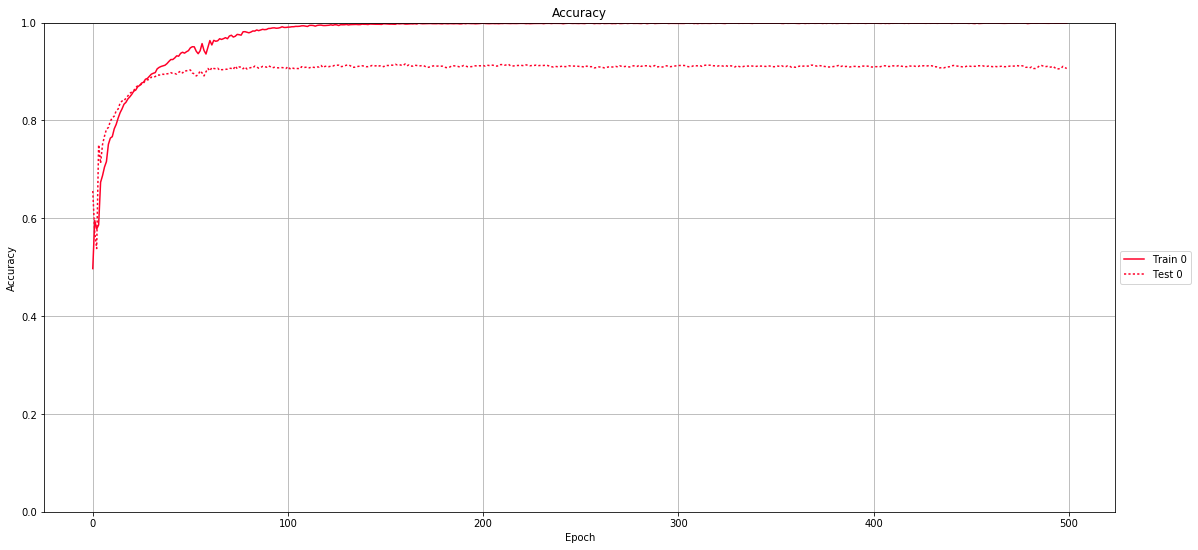

In [11]:
plot_acc(history)

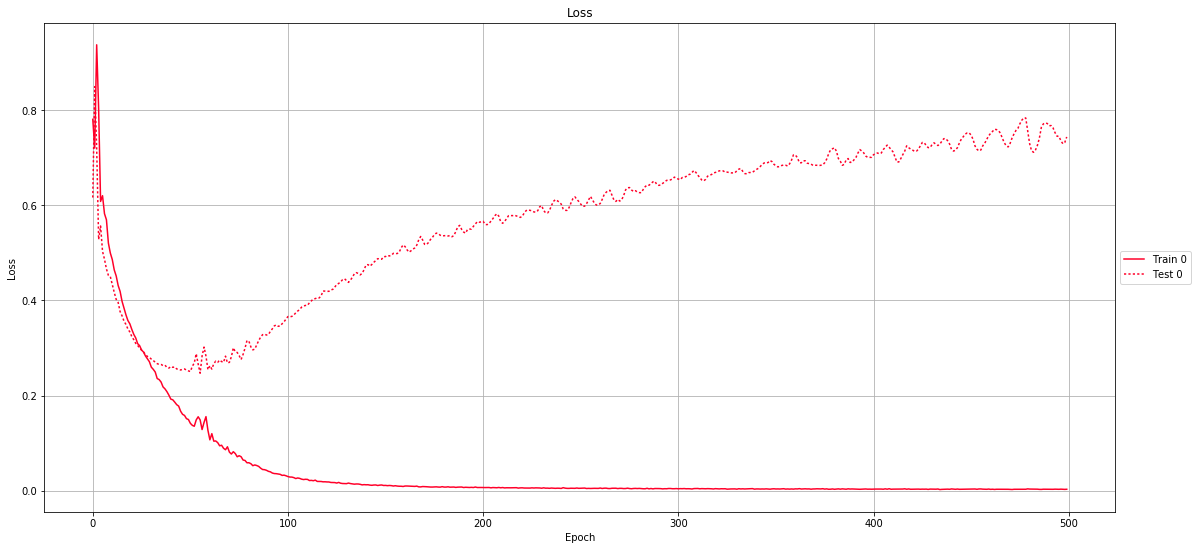

In [12]:
plot_loss(history)

In [13]:
# Viewing the confusion matrix
conf_mat = conf_mat.T  # since rows and cols are interchangeable
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix

Plotting the confusion matrix


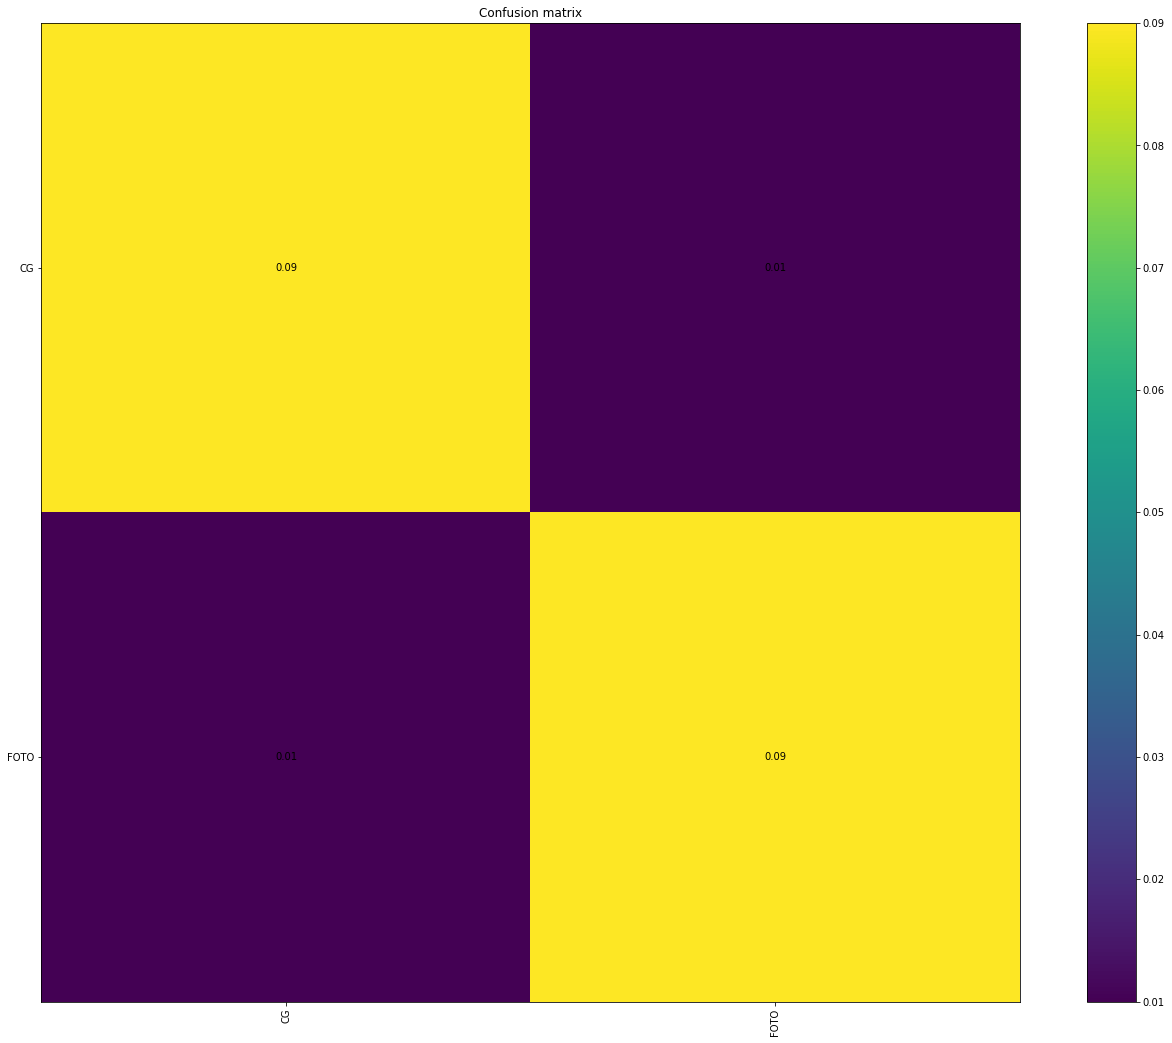

In [14]:
print("Plotting the confusion matrix")
conf_mat = numpy.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(24, 18)
plt.imshow(conf_mat,interpolation='nearest')
for row in xrange(len(list_fams)):
    for col in xrange(len(list_fams)):
        plt.annotate(str(conf_mat[row][col]),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.title('Confusion matrix')
plt.colorbar()
plt.show()